# Setup


## Colab

In [1]:
# # Mount the drive and move to dir
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Switch to current dir
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [3]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os
import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import the utilities and the dataloader
from utils import trainutil, inferutil, setuputil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)

# Import the funcs needed from utils
from utils.setuputil import setup_config, display_config
from utils.trainutil import train_model
from utils.inferutil import infer_one, infer_full


## Configuration

In [4]:
# Define the input config file
input_config = {
    # Environment and Model Info
    "env": "colab",
    "approach": "bert",
    "model_name": "BertTiny",
    "model_base": "prajjwal1/bert-tiny",

    # System Configuration
    "device": "cuda:0",
    "threads": 10,
    "seed": 42,

    # Data Configuration
    "data_dir": "../data",
    "data_ds": "manual",

    # Model Parameters
    "rows": 100,
    "cols": 100,
    "tokens": 16,

    # Training Parameters
    "batch": 14,
    "lr": 1e-3,
    "mu": 0.25,
    "epochs": 10,
    "patience": 2,
    "save_int": 5,
    "save_dir": '../models/'
}
config = setup_config(input_config)
display_config(config)

Processing files: 100%|██████████| 40/40 [00:09<00:00,  4.04it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3172.70it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 2379.88it/s]



5(P) = 5(G) + 0(E)

Configuration for BERT approach:
{
  "env": "colab",
  "approach": "bert",
  "model_base": "prajjwal1/bert-tiny",
  "model_name": "BertTiny",
  "rows": 100,
  "cols": 100,
  "tokens": 16,
  "DEVICE": "cuda:0",
  "THREADS": 10,
  "seed": 42,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BERT Tokenizer Object>",
  "train_loader": "<LoaderBert Object>",
  "val_loader": "<LoaderBert Object>",
  "test_loader": "<LoaderBert Object>",
  "batch": 14,
  "lr": 0.001,
  "mu": 0.25,
  "epochs": 10,
  "patience": 2,
  "save_int": 5,
  "save_dir": "../models/",
  "save_name": "cber42_BertTiny_manual_100x100x16_bsz14lr1e-3ep10pa2"
}


In [5]:
# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]
#gber42_TinyBert_manual_100x100x32
# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config['model_base']

# Training parameters
batch_size = config["batch"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

# Model Creation

In [6]:
import torch
import torch.nn as nn
from transformers import AutoModel
from tqdm import tqdm
import math

class BertTiny(nn.Module):
    def __init__(self, model_base="prajjwal1/bert-tiny", dropout_rate=0.05):
        super(BertTiny, self).__init__()

        # 1. Load pretrained BERT
        self.bert = AutoModel.from_pretrained(model_base)

        # 2. Define a dropout
        self.dropout = nn.Dropout(dropout_rate)

        # 3. Non-linear activation (GELU)
        self.gelu = nn.GELU()

        # 4. Final predictor (1-dim output per cell)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)


    def forward(self, input_ids, attention_mask):

        # 1) Allocate the (batch_size, rows, cols) S_cube
        S_cube = torch.zeros(
            (input_ids.shape[0], input_ids.shape[1], input_ids.shape[2]),
            device=input_ids.device,
        )

        # 2) Loop over cells in row-major order
        for cell in range(input_ids.shape[1] * input_ids.shape[2]):

            # In one shot, store logits → S_cube
            # cell // input_ids.shape[2] = row, cell % input_ids.shape[2] = col
            S_cube[
                :, cell // input_ids.shape[2], cell % input_ids.shape[2]
            ] = self.classifier(
                self.gelu(
                    self.dropout(
                        self.bert(
                            input_ids[
                                :,
                                cell // input_ids.shape[2],
                                cell % input_ids.shape[2],
                                :,
                            ],
                            attention_mask=attention_mask[
                                :,
                                cell // input_ids.shape[2],
                                cell % input_ids.shape[2],
                                :,
                            ],
                        ).pooler_output
                    )
                )
            ).view(
                -1
            )

        return S_cube

In [7]:
# 1) Create model and move to GPU Observe its architecture
untrained_model = BertTiny(model_base=model_base).to(DEVICE)
print(untrained_model)

BertTiny(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine

In [8]:
# Imports
import os  # For file and directory operations
import time  # For generating the timestamp in filenames
import torch  # Core PyTorch library
import torch.nn as nn  # For defining loss functions
import math  # For calculating exponential in perplexity calculation
from tqdm import tqdm  # For progress bars in training and validation loops
import sys
from sklearn.metrics import precision_score, recall_score, f1_score


# ------------------------------------------------------------------------
# Define a new function to train the BertTiny model using attention masks
def train_bert(model, train_data, val_data, DEVICE, batch_size=8, lr=1.4e-5, mu=0.25, max_epochs=4, patience=3, save_int=2, save_dir='../models/', save_name='bert_', config=None):

    # --------------------------------------------------------------------
    # Everything remains the same up until we get to the forward pass.
    # We still set up logging, create train_loader, val_loader, define loss, etc.
    # --------------------------------------------------------------------

    # Set the option in torch to print full tensor
    torch.set_printoptions(profile="full")

    # Check if save_int > 0 and save_dir exists
    if save_int > 0 and not os.path.exists(save_dir):
        raise ValueError(f"Directory '{save_dir}' DNE")

    # Generate timestamp for naming checkpoints and logs
    timestamp = time.strftime("%Y%m%d_%H%M%S")

    # Construct checkpoint paths
    model_path = os.path.join(save_dir, f"{save_name}_{timestamp}.pth")
    log_file = os.path.join(save_dir, f"{save_name}_{timestamp}.txt")

    # Write config to log if provided (and remove non-serializable items)
    if config is not None and save_int > 0:
        import json
        import copy

        config_serializable = copy.deepcopy(config)
        del config_serializable["DEVICE"]
        del config_serializable["train_loader"]
        del config_serializable["val_loader"]
        del config_serializable["test_loader"]
        del config_serializable["tokenizer"]

        with open(log_file, 'w') as log:
            log.write("\nFinal configuration:\n")
            log.write(json.dumps(config_serializable, indent=2))
            log.write("\n\n" + "="*80 + "\n\n")

    # --------------------------------------------------------------------
    # Create optimizer as before
    opt = torch.optim.Adagrad(model.parameters(), lr=lr)

    # Create the DataLoader for train and validation sets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Calculate class imbalance as before
    num_bold_cells = sum((batch['y_tok'][:, :, :, 6] == 1).sum() for batch in train_loader)
    num_nonbold_cells = sum((batch['y_tok'][:, :, :, 6] == 0).sum() for batch in train_loader)
    class_imbalance = num_nonbold_cells / num_bold_cells

    # Binary cross-entropy loss with logits
    loss_fn = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([class_imbalance], dtype=torch.float).to(DEVICE)
    )

    # Initialize training parameters
    epoch = 0
    best_avgtrloss = float('inf')
    best_perp = float('inf')
    best_epoch = 0
    best_avgvalloss = float('inf')
    best_valperp = float('inf')
    nimp_ctr = 0
    training = True

    # --------------------------------------------------------------------
    # Main training loop
    # --------------------------------------------------------------------
    while training and (epoch < max_epochs):

        print(f'Epoch {epoch}')
        if save_int > 0:
            with open(log_file, 'a') as log:
                log.write(f"\nEpoch {epoch}\n")

        curr_trloss, curr_valloss = 0, 0

        # Put model in train mode
        model.train()

        # ----------------------------------------------------------------
        # Train step
        # ----------------------------------------------------------------
        for i, batch in enumerate(tqdm(train_loader, desc='Batch Processing')):

            # Zero out gradients
            model.zero_grad()

            # ----------------------------------------------------------------
            # CHANGED LINE: Now pass both input_ids and attention_mask to model
            logits = model(
                batch['x_tok'].to(DEVICE),
                batch['x_masks'].to(DEVICE)   # <--- Pass attention_mask here
            ).view(-1)

            # ----------------------------------------------------------------
            # Same as original: define labels
            labels = batch['y_tok'][:, :, :, 6].to(DEVICE).view(-1).float()

            # Compute loss
            loss = loss_fn(logits, labels)

            # Accumulate training loss
            curr_trloss += loss.detach().cpu().item()

            # Backprop
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=mu)

            # Update model parameters
            opt.step()

            # Clear memory
            del loss

        # Put model in eval mode
        model.eval()

        # ----------------------------------------------------------------
        # Validation step
        # ----------------------------------------------------------------
        for i, batch in enumerate(tqdm(val_loader, desc='Validation Processing')):
            with torch.no_grad():

                # ----------------------------------------------------------------
                # CHANGED LINE: Pass both input_ids and attention_mask to model
                val_logits = model(
                    batch['x_tok'].to(DEVICE),
                    batch['x_masks'].to(DEVICE)  # <--- Pass attention_mask here
                ).view(-1)

                # Labels remain the same
                val_labels = batch['y_tok'][:, :, :, 6].to(DEVICE).view(-1).float()

                # Compute validation loss
                val_loss = loss_fn(val_logits, val_labels)

                curr_valloss += val_loss.detach().cpu().item()

        # ----------------------------------------------------------------
        # Same perplexity calculations as original
        # ----------------------------------------------------------------
        curr_avgtrloss = curr_trloss / len(train_loader)
        curr_perp = math.exp(curr_trloss / (len(train_loader) * batch_size * 2500))
        curr_avgvalloss = curr_valloss / len(val_loader)
        curr_valperp = math.exp(curr_valloss / (len(val_loader) * batch_size * 2500))

        # Print stats
        print(f'Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}')
        print(f'Val Loss: {curr_avgvalloss}, Perplexity: {curr_valperp}\n')
        if save_int > 0:
            with open(log_file, 'a') as log:
                log.write(f'Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}\n')
                log.write(f'Val Loss: {curr_avgvalloss}, Perplexity: {curr_valperp}\n')

        # Early stopping checks
        if curr_valperp < best_valperp:
            best_perp = curr_perp
            best_valperp = curr_valperp
            best_avgtrloss = curr_avgtrloss
            best_avgvalloss = curr_avgvalloss
            best_epoch = epoch
            nimp_ctr = 0
        else:
            nimp_ctr += 1

        if nimp_ctr >= patience:
            print(f'\nEARLY STOPPING at epoch {epoch}, best epoch {best_epoch}')
            print(f'Train Loss = {best_avgtrloss}, Perplexity = {best_perp}')
            print(f'Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}')
            if save_int > 0:
                with open(log_file, 'a') as log:
                    log.write(f'\nEARLY STOPPING at epoch {epoch}, best epoch {best_epoch}\n')
                    log.write(f'Train Loss = {best_avgtrloss}, Perplexity = {best_perp}\n')
                    log.write(f'Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}\n')
            training = False

        # Save model periodically
        if save_int > 0 and (epoch + 1) % save_int == 0:
            torch.save(model.state_dict(), model_path)
            print("Model Saved")
            with open(log_file, 'a') as log:
                log.write("Model Saved\n")

        epoch += 1
        print()

    # Final save
    if save_int > 0:
        torch.save(model.state_dict(), model_path)

    # Print final results
    print(f'\nTRAINING DONE at epoch {epoch-1}, best epoch {best_epoch}')
    print(f'Train Loss = {best_avgtrloss}, Perplexity = {best_perp}')
    print(f'Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}')
    if save_int > 0:
        with open(log_file, 'a') as log:
            log.write(f'\nTRAINING DONE at epoch {epoch-1}, best epoch {best_epoch}\n')
            log.write(f'Train Loss = {best_avgtrloss}, Perplexity = {best_perp}\n')
            log.write(f'Val Loss = {best_avgvalloss}, Perplexity = {best_valperp}\n')

    return model


In [9]:
# # Call the train_bert function with the loaded model and config hyperparameters
trained_model = train_bert(
    untrained_model,                  # Pass the BertTiny model
    train_loader,   # Training dataset
    val_loader,     # Validation dataset
    DEVICE,                 # Device for computation (CPU/GPU)
    batch_size=batch_size,  # Batch size from config
    lr=lr,                  # Learning rate from config
    mu=mu,                  # Gradient clipping max norm from config
    max_epochs=epochs,      # Maximum number of epochs from config
    patience=patience,      # Early stopping patience
    save_int=save_int,      # Interval at which to save model
    save_dir=save_dir,      # Directory path to save checkpoints
    save_name=save_name,    # Base name used for saving checkpoints/logs
    config=config           # Full config for logging
)



Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:22<00:00, 22.62s/it]


Train Loss: 1.1519421537717183, Perplexity: 1.0000329131745915
Val Loss: 0.731855034828186, Perplexity: 1.0000209103624709


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:22<00:00, 22.75s/it]


Train Loss: 0.6875163714090983, Perplexity: 1.0000196435178288
Val Loss: 0.4187546372413635, Perplexity: 1.000011964489781


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:22<00:00, 22.55s/it]


Train Loss: 0.43405912319819134, Perplexity: 1.0000124017661356
Val Loss: 0.29449328780174255, Perplexity: 1.0000084141293357


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:23<00:00, 23.03s/it]


Train Loss: 0.3129208783308665, Perplexity: 1.000008940636491
Val Loss: 0.23815639317035675, Perplexity: 1.0000068044915267


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:22<00:00, 22.83s/it]


Train Loss: 0.2540591061115265, Perplexity: 1.0000072588579485
Val Loss: 0.20240826904773712, Perplexity: 1.0000057831101234

Model Saved

Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:22<00:00, 22.59s/it]


Train Loss: 0.21390034755071005, Perplexity: 1.0000061114571763
Val Loss: 0.1730448454618454, Perplexity: 1.000004944150664


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:22<00:00, 22.59s/it]


Train Loss: 0.18254104256629944, Perplexity: 1.0000052154719596
Val Loss: 0.14699922502040863, Perplexity: 1.0000041999866776


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:22<00:00, 22.51s/it]


Train Loss: 0.15861471990744272, Perplexity: 1.000004531859409
Val Loss: 0.1320303976535797, Perplexity: 1.000003772304191


Epoch 8


Validation Processing: 100%|██████████| 1/1 [00:22<00:00, 22.59s/it]


Train Loss: 0.14171247680981955, Perplexity: 1.0000040489361057
Val Loss: 0.12068536877632141, Perplexity: 1.0000034481593385


Epoch 9


Validation Processing: 100%|██████████| 1/1 [00:22<00:00, 22.51s/it]


Train Loss: 0.12802020708719888, Perplexity: 1.000003657726892
Val Loss: 0.11057222634553909, Perplexity: 1.0000031592114573

Model Saved


TRAINING DONE at epoch 9, best epoch 9
Train Loss = 0.12802020708719888, Perplexity = 1.000003657726892
Val Loss = 0.11057222634553909, Perplexity = 1.0000031592114573



Filename: ../data/manual_train/portfoliobyloanstatus copy.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(4,10): 0.92226397991180419922
(28,0): 0.93247485160827636719
(38,0): 0.93271589279174804688
(4,6): 0.93273884057998657227
(4,4): 0.93274170160293579102
(36,0): 0.93296736478805541992
(4,2): 0.93321812152862548828
(4,14): 0.93331396579742431641
(32,0): 0.93343973159790039062
(6,0): 0.93347066640853881836
(12,0): 0.93352055549621582031
(8,0): 0.93358606100082397461
(24,0): 0.93358927965164184570
(16,0): 0.93359303474426269531
(20,0): 0.93360346555709838867
(4,8): 0.93439906835556030273
(5,0): 0.93470454216003417969
(0,0): 0.93479770421981811523
(4,12): 0.93481558561325073242
(5,3): 0.93496376276016235352
(5,2): 0.93497323989868164062
(6,1): 0.93514865636825561523
(7,1): 0.93514895439147949219
(9,1): 0.93515181541442871094
(8,1): 0.93517315387725830078
(37,1): 0.93531310558319091797

NB to B ratio: Predicted = 9868:132 | Actual = 9874:126
Accuracy: 99.94% | Precision: 95.45

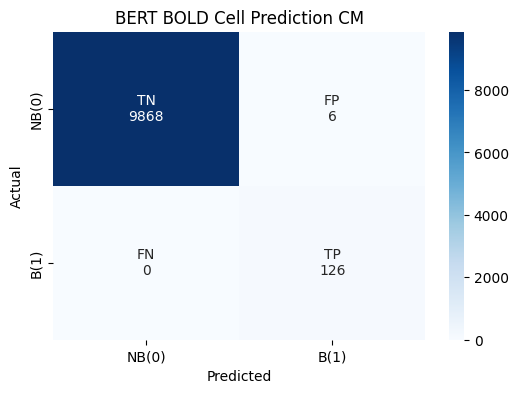


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
from utils import inferutil
importlib.reload(inferutil)
from utils.inferutil import binfer_one

# Params
loc = 0
thresh = 0.8
cond = '>'
disp_max=True

# inference on single position of train loader params
binfer_one(
    trained_model,
    train_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../data/manual_val/ffelbydefermenttype.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(5,10): 0.93126881122589111328
(5,12): 0.93132025003433227539
(5,16): 0.93135011196136474609
(23,0): 0.93247485160827636719
(5,2): 0.93285924196243286133
(31,0): 0.93296736478805541992
(5,14): 0.93331396579742431641
(27,0): 0.93343973159790039062
(0,0): 0.93351513147354125977
(7,0): 0.93352055549621582031
(19,0): 0.93358927965164184570
(11,0): 0.93359303474426269531
(15,0): 0.93360346555709838867
(5,8): 0.93364799022674560547
(5,6): 0.93371295928955078125
(5,4): 0.93444186449050903320
(6,0): 0.93470454216003417969
(6,3): 0.93496376276016235352
(6,2): 0.93497323989868164062
(9,1): 0.93514865636825561523
(10,1): 0.93514895439147949219
(8,1): 0.93515181541442871094
(7,1): 0.93517315387725830078

NB to B ratio: Predicted = 9837:163 | Actual = 9896:104
Accuracy: 99.41% | Precision: 63.80% | Recall: 100.00% | F1-Score: 0.78



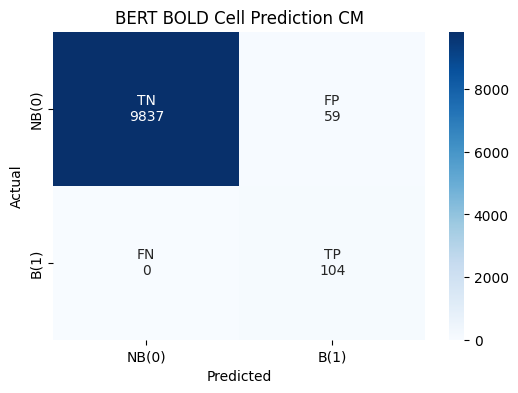


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
binfer_one(
    trained_model,
    val_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)


Filename: ../data/manual_test/dlportfoliobyrepaymentplan.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(5,4): 0.25767335295677185059
(5,8): 0.37277036905288696289
(5,6): 0.79966586828231811523
(5,2): 0.81256449222564697266
(5,14): 0.84881877899169921875
(29,0): 0.93247485160827636719
(37,0): 0.93296736478805541992
(5,20): 0.93331396579742431641
(5,16): 0.93331676721572875977
(33,0): 0.93343973159790039062
(7,0): 0.93347066640853881836
(13,0): 0.93352055549621582031
(5,18): 0.93358445167541503906
(9,0): 0.93358606100082397461
(25,0): 0.93358927965164184570
(17,0): 0.93359303474426269531
(21,0): 0.93360346555709838867
(5,12): 0.93362122774124145508
(0,0): 0.93456274271011352539
(6,0): 0.93470454216003417969
(6,3): 0.93496376276016235352
(6,2): 0.93497323989868164062
(7,1): 0.93514865636825561523
(8,1): 0.93514895439147949219
(10,1): 0.93515181541442871094
(9,1): 0.93517315387725830078
(5,10): 0.93517649173736572266

NB to B ratio: Predicted = 9844:156 | Actual = 9872:128
Accu

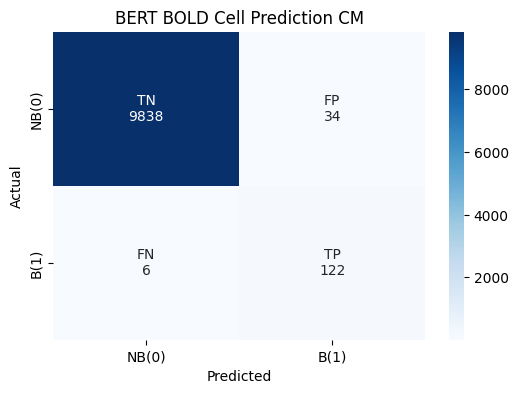


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
binfer_one(
    trained_model,
    test_loader,
    loc=loc,
    threshold=thresh,
    condition=cond,
    disp_max=disp_max,
    device=DEVICE
)

Batch Inference: 100%|██████████| 20/20 [07:15<00:00, 21.77s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 396633:3367 | Actual = 396714:3286
Accuracy: 99.98% | Precision: 97.34% | Recall: 99.82% | F1-Score: 0.99



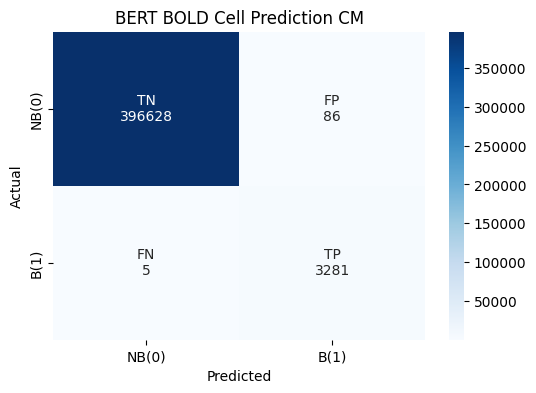

In [16]:
from utils import inferutil
importlib.reload(inferutil)
from utils.inferutil import binfer_full

binfer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=2,
    threshold=thresh,
    device=DEVICE
)


Batch Inference: 100%|██████████| 3/3 [01:05<00:00, 21.95s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49532:468 | Actual = 49602:398
Accuracy: 99.87% | Precision: 88.54% | Recall: 99.52% | F1-Score: 0.93



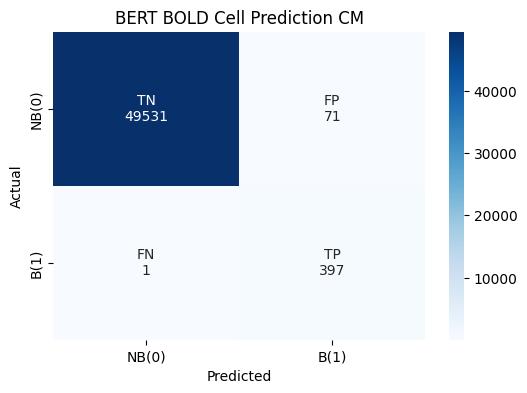

In [14]:
binfer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=2,
    threshold=thresh,
    device=DEVICE
)

Batch Inference: 100%|██████████| 3/3 [01:04<00:00, 21.57s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49567:433 | Actual = 49606:394
Accuracy: 99.91% | Precision: 91.38% | Recall: 98.72% | F1-Score: 0.95



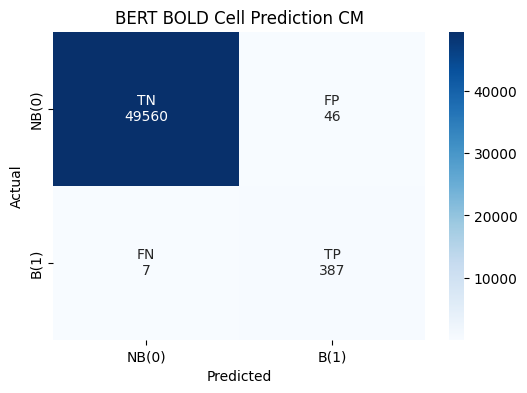

In [15]:
binfer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=2,
    threshold=thresh,
    device=DEVICE
)